In [1]:
!pip install -U --pre tensorflow-gpu --quiet

     |████████████████████████████████| 348.9MB 55kB/s 
     |████████████████████████████████| 3.1MB 49.1MB/s 
     |████████████████████████████████| 501kB 52.3MB/s 


In [2]:
!pip install 'tensorflow-hub>=0.3'

In [3]:
from __future__ import absolute_import, division, print_function

import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub


#tensorflow2.0に組み込まれたkerasから呼び出し
#https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/image
from tensorflow.keras.preprocessing.image import img_to_array,load_img


print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-beta1
Eager mode:  True
Hub version:  0.5.0
GPU is available


## トレーニング済みのModelを選択

In [4]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


## 転移学習させる対象のデータを準備

In [5]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [0]:
"""
tensorflow hubで事前トレーニングされたモデルを転移学習する方法。
分類したい画像は階層分けしたフォルダで用意しておく。
フォルダ名がそのままclass nameになるので英語表記する

data--
          class1
              -some.jpg
              -some.jpg
              -some.jpg
          class2
              -some.jpg
              -some.jpg
          class3
              -some.jpg
              -some.jpg
              -some.jpg
              -some.jpg
"""

In [0]:
#今回用意されている花のディレクトリはdaisy　　dandelion 　roses　 sunflowers　 tulipsの５つ
#daisy/633枚  dandelion/898枚   roses/641枚  sunflowers/699枚  tulips/799枚    合計 3670枚

daisy/  dandelion/  LICENSE.txt  roses/  sunflowers/  tulips/


##画像データの水増し処理

In [6]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

#インスタンス準備
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
#validationジェネレーターを作成
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False,
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)


#データの水増し処理
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen


#trainningジェネレーターを作成
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True,
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)


Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [0]:
#上記Flowers datasetでは、validationに５クラス731枚（１クラス平均１４６枚）
#trainに５クラス2939枚（１クラス平均587枚）の写真を用意している
#という事で、独自modelで同程度の精度を出そうとすれば１クラス７００枚程度の写真が必要

In [0]:
dir(train_generator)

#train_generatorをdir()で調べた際の主なfunction

#train_generator.target_size     (224, 224)
#train_generator.num_classes    5
#train_generator.labels    array([0, 0, 0, ..., 4, 4, 4], dtype=int32)
#train_generator.image_shape   (224, 224, 3)
#train_generator.batch_size   32
#train_generator.n   2939


## Modelの定義

In [0]:
#fine_tuningした方が精度が上がるが、fitに時間がかかる
do_fine_tuning = True #@param {type:"boolean"}

In [8]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
                   hub.KerasLayer(MODULE_HANDLE, output_shape=[FV_SIZE],
                   trainable=do_fine_tuning),
                   tf.keras.layers.Dropout(rate=0.2),
                   tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                   kernel_regularizer=tf.keras.regularizers.l2(0.0001))
                ])

model.build((None,)+IMAGE_SIZE+(3,)) #(None,299,299,3)になる
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  21802784  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


## Modelのトレーニング

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  #optimizer=tf.keras.optimizers.Adam(), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

###Adamでは全然精度が出なかった（5epochで81.6。SGDは94.6）　ただ上昇傾向なのでepochをふもっと増やすとどこまで行くか？

In [10]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

#ジェネレーターを使った場合はmodel.fitではなくmodel.fit_generatorを使う
hist = model.fit_generator(
    train_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/10


W0807 11:40:31.987771 139944169985920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


91/91 [==============================] - 186s 2s/step - loss: 1.0266 - accuracy: 0.6894 - val_loss: 1.0312 - val_accuracy: 0.8267
Epoch 2/10
91/91 [==============================] - 113s 1s/step - loss: 0.7812 - accuracy: 0.9338 - val_loss: 0.9794 - val_accuracy: 0.8622
Epoch 3/10
91/91 [==============================] - 112s 1s/step - loss: 0.7454 - accuracy: 0.9511 - val_loss: 0.7906 - val_accuracy: 0.9261
Epoch 4/10
91/91 [==============================] - 112s 1s/step - loss: 0.7170 - accuracy: 0.9681 - val_loss: 0.8074 - val_accuracy: 0.9077
Epoch 5/10
91/91 [==============================] - 112s 1s/step - loss: 0.6982 - accuracy: 0.9777 - val_loss: 0.7807 - val_accuracy: 0.9332
Epoch 6/10
91/91 [==============================] - 111s 1s/step - loss: 0.6829 - accuracy: 0.9816 - val_loss: 0.7581 - val_accuracy: 0.9432
Epoch 7/10
91/91 [==============================] - 111s 1s/step - loss: 0.6745 - accuracy: 0.9817 - val_loss: 0.7981 - val_accuracy: 0.9304
Epoch 8/10
91/91 [======

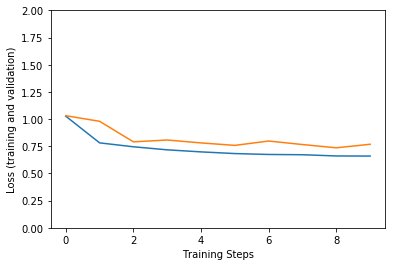

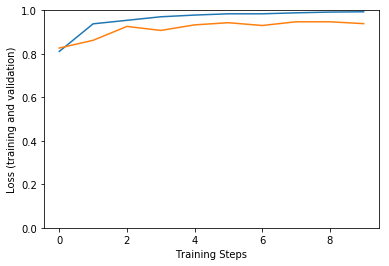

In [11]:
#LossとAccuracyの確認
#4Epoch以降はほぼ横ばい

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

##画像を予測してみる

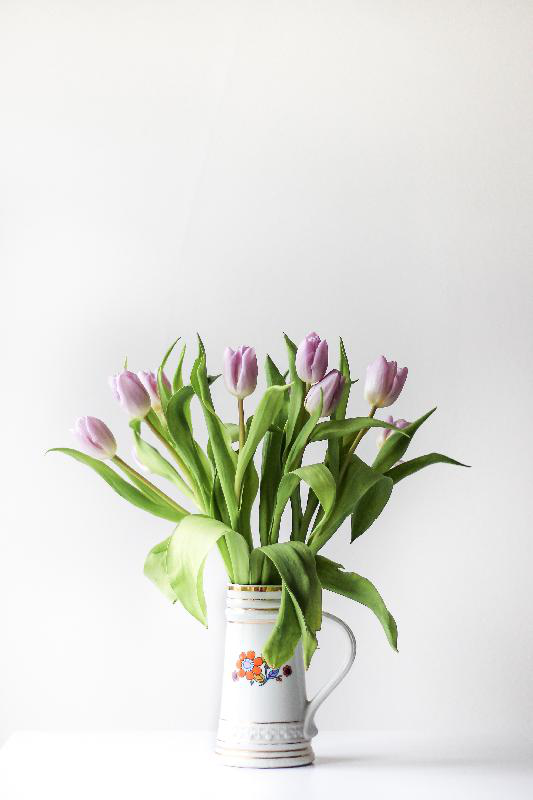

In [18]:
#https://unsplash.comからtulip画像をダウンロード

from PIL import Image
Image.open("tulip.jpg")

In [0]:
#単品jpgイメージをpredictをするための変換処理


img_path = "tulip.jpg"


img = load_img(img_path,target_size=(299,299))
#イメージ読み込みと同時にリサイズ
#この時点のオブジェクトはPIL.Image.Image


x = img_to_array(img)
#PIL.Image.Imageをarrayに変換
#この時点のshapeは(299, 299, 3) のnumpy ndarray


x = x/255
#0-1への正規化


x = np.expand_dims(x,axis=0)
#np.expand_dims()でkeras用のshapeに変換
#この時点のshapeは(1, 299, 299, 3) のnumpy ndarray


In [20]:
#学習済みモデルで予測

model.predict(x)

array([[0.01300805, 0.01730114, 0.3057519 , 0.02211936, 0.64181954]],
      dtype=float32)

###daisy, dandelion, roses, sunflowers, tulipsの5つのラベルのうち、5番目の数値が0.64181954と一番高く、この画像はtulipsであると正しく予測できている